#### Лабораторная работа №2. Ковалёва Елена Сергеевна. 20152.

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB 
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
import operator

1. Загружаем таблицу Mushroom из репозитория UCI (любого источника) в объект DataFrame.

In [9]:
features = ['cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor', 
             'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
             'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
             'stalk-surface-below-ring', 'stalk-color-above-ring', 'stalk-color-below-ring',
             'veil-type', 'veil-color', 'ring-number', 'ring-type', 'spore-print-color',
             'population', 'habitat']
dset = pd.read_csv('agaricus-lepiota.data', names=['class'] + features)
data_x = dset[features]
data_y = dset['class']

object_count = data_x.shape[0]
features_count = data_x.shape[1]

In [10]:
dset.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [11]:
dset.shape

(8124, 23)

Вычисляем распределение значений категориальных признаков по классам. Визуализируем распределения.

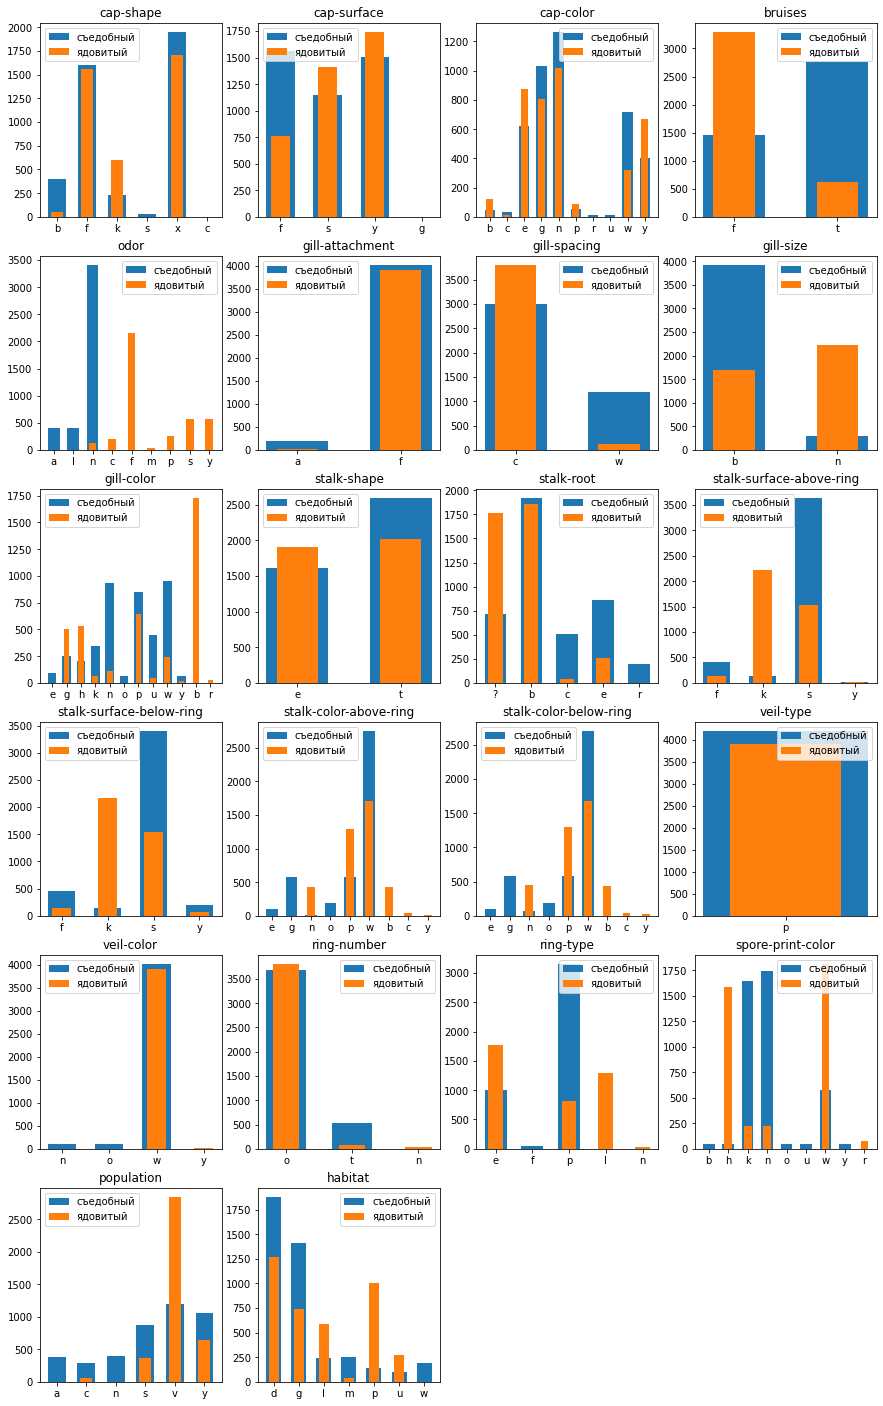

In [12]:
fig, axs = plt.subplots(6, 4, figsize=(15,25))
for i in range(6):
    for j in range(4):
        if i*4 + j >= features_count:
            axs[i, j].axis('off')
            continue
        feature = features[i*4+j]         
        edible_feature_values, edible_feature_values_counts = \
            np.unique(data_x[data_y == 'e'][feature], return_counts=True)
        poisonous_feature_values, poisonous_feature_values_counts = \
            np.unique(data_x[data_y == 'p'][feature], return_counts=True)
        
        axs[i, j].bar(edible_feature_values, edible_feature_values_counts, width=0.6, label='съедобный')
        axs[i, j].bar(poisonous_feature_values, poisonous_feature_values_counts, width=0.4, label='ядовитый')
        axs[i, j].set_title(feature)
        axs[i, j].legend()
        
        edible_distributions = dict(zip(edible_feature_values, edible_feature_values_counts/object_count))
        poisonous_distributions = dict(zip(edible_feature_values, poisonous_feature_values_counts/object_count))

Для **odor(n/r)** и **spore-print-color(kn/hw)** видно четкое разделение.

Разбиваем данные на обучающую и контрольную выборки.

In [13]:
encoder = OneHotEncoder().fit(data_x)
data_x_onehot = encoder.transform(data_x).toarray()
data_x_train, data_x_test, data_y_train, data_y_test = \
    train_test_split(data_x_onehot, data_y, test_size=0.3)

2. Cтроим решающую функцию по каждой переменной на основе частот.\
Сравниваем точность на обучающей и контрольной выборках.\
Находим наиболее информативную переменную.

In [14]:
class FreqDiscriminator:
    def fit(self, x, y):
        y_classes, y_probs = list(np.unique(y, return_counts=True))
        y_probs = y_probs / y.shape[0]        
        self.y_probs = dict(zip(y_classes, y_probs))
        
        self.x_probs_by_y = {}
        for y_class in y_classes:
            x_by_y = x[y == y_class]
            self.x_probs_by_y[y_class] = sum(x_by_y)/x_by_y.shape[0]
        
    def pred(self, val):
        probs = {}
        for y in self.x_probs_by_y.keys():
            probs[y] = self.y_probs[y] * sum(self.x_probs_by_y[y]*val)
        return max(probs.items(), key=operator.itemgetter(1))[0]
        
    def predict(self, x):
        return np.asarray([self.pred(val) for val in x])

feature_start_index = 0
for i in range(len(features)):
    fd = FreqDiscriminator()
    category = encoder.categories_[i]
    feature_range = range(feature_start_index, feature_start_index+len(category))
    fd.fit(data_x_train[:, feature_range], data_y_train)
    y_pred_train = fd.predict(data_x_train[:, feature_range])
    y_pred_test = fd.predict(data_x_test[:, feature_range])
    print(f'точность [обучающая, {features[i]}]:', 
          len(y_pred_train[y_pred_train == data_y_train])/len(data_y_train))
    print(f'точность [контрольная, {features[i]}]:', 
          len(y_pred_test[y_pred_test == data_y_test])/len(data_y_test))
    feature_start_index += len(category)

точность [обучающая, cap-shape]: 0.5647203658107632
точность [контрольная, cap-shape]: 0.5631665299425759
точность [обучающая, cap-surface]: 0.5798452339078438
точность [контрольная, cap-surface]: 0.5820344544708778
точность [обучающая, cap-color]: 0.5942666197678509
точность [контрольная, cap-color]: 0.5976210008203445
точность [обучающая, bruises]: 0.7423496306718256
точность [контрольная, bruises]: 0.7477440525020509
точность [обучающая, odor]: 0.9855786141399929
точность [контрольная, odor]: 0.9844134536505332
точность [обучающая, gill-attachment]: 0.5196975026380584
точность [контрольная, gill-attachment]: 0.5139458572600493
точность [обучающая, gill-spacing]: 0.6148434752022511
точность [контрольная, gill-spacing]: 0.6185397867104184
точность [обучающая, gill-size]: 0.753253605346465
точность [контрольная, gill-size]: 0.7633305988515177
точность [обучающая, gill-color]: 0.8079493492789307
точность [контрольная, gill-color]: 0.7981952420016407
точность [обучающая, stalk-shape]: 0.

самая информативная переменная **odor**

3. Строим «наивный» байесовский классификатор из sklearn. Оцениваем точность.

In [16]:
model = BernoulliNB()
model.fit(data_x_train, data_y_train)

sk_nb_y_pred_train = model.predict(data_x_train)
sk_nb_y_pred_test = model.predict(data_x_test)

print('Точность[обучающая]:', 
      len(sk_nb_y_pred_train[sk_nb_y_pred_train == data_y_train])/len(data_y_train))
print('Точность[контрольная]:', 
      len(sk_nb_y_pred_test[sk_nb_y_pred_test == data_y_test])/len(data_y_test))

Точность[обучающая]: 0.9400281392894829
Точность[контрольная]: 0.9380639868744873


Высокая точность классификации

4. Самостоятельно реализуем метод. Оцениваем точность.

In [17]:
class NaiveBayes:
    def fit(self, x, y):
        probs = {}
        y_classes = list(np.unique(y))
        for y_class in y_classes:
            x_by_y = x[y == y_class]
            x_probs_by_y = []
            for pos in range(x.shape[1]):
                x_by_y_pos = x_by_y[:,pos]
                # +1 и +2 - регулязизатор
                one_prob = (x_by_y_pos.sum()+1) / (x_by_y_pos.shape[0]+2) 
                zero_prob = 1 - one_prob
                x_probs_by_y.append((zero_prob, one_prob))
            probs[y_class] = x_probs_by_y
        self.probs = probs
    
    def pred(self, row):
        probs = {}
        for y in self.probs.keys():
            prob = 1
            for pos in range(len(row)):
                prob *= self.probs[y][pos][int(row[pos])]
            probs[y] = prob
        return max(probs.items(), key=operator.itemgetter(1))[0]
    
    def predict(self, x):
        return np.apply_along_axis(self.pred, 1, x)
    
nb = NaiveBayes()
nb.fit(data_x_train, data_y_train)

nb_y_pred_train = nb.predict(data_x_train)
nb_y_pred_test = nb.predict(data_x_test)

print('Точность [обучающая]:', 
      len(nb_y_pred_train[nb_y_pred_train == data_y_train])/len(data_y_train))
print('Точность [контрольная]:', 
      len(nb_y_pred_test[nb_y_pred_test == data_y_test])/len(data_y_test))

Точность [обучающая]: 0.9396763981709462
Точность [контрольная]: 0.938884331419196


Точность классификации близка с библиотечной реализацией